# Accessing and managing users
Users are an indispensible part of your web GIS. As the number of users grow, you can see value in automating your management tasks such as provisioning licenses, privileges, creating and removing user accounts etc. The `gis` module provides you with `User` and `UserManager` classes to respresent users as objects and help you accomplish the most common tasks. In this guide, we will learn about:

 * [About your account](#about-your-account)
 * [Properties of a `User` object](#properties-of-a-user-object)
 * [Searching for user accounts](#searching-for-user-accounts)
 * [Creating new user accounts](#creating-new-user-accounts)
  * [About user roles](#about-user-roles)
  * [Managing user roles](#managing-user-roles)
    * [Creating new roles](#creating-new-roles)
    * [Creating a user with a custom role](#creating-a-user-with-a-custom-role)
    * [Listing all the custom roles in an org](#listing-all-the-custom-roles-in-an-org)
 * [Deleting user accounts](#deleting-user-accounts)
  * [Accessing user content](#accessing-user-content)
  * [Reassigning user content](#reassigning-user-content)

As you might have seen the pattern with `ContentManager` and `Item` objects, the `UserManager` object is a resource manager that gives you access to `User` objects. You access a `UserManager` object not by instantiating that class through its constructor, but by accessing the `users` property of your `GIS` object. This is the typical pattern of usage throughout the `gis` module.

<a id="about-your-account"></a>
## About your account
Let us get to know a bit about our logged in account before we observe how to manage other user accounts. Let us import the `GIS` class from `gis` module and connect to an ArcGIS Enterprise:

In [1]:
from arcgis.gis import GIS
gis = GIS("portal url", "username", "password")

You can access your user account by accessing `me` property as shown below:

In [2]:
me = gis.users.me
me

<User username:arcgis_python_api>

Similar to `Item` objects, when using the Jupyter notebook IDE, you can visualize `User` objects in rich HTML representation with thumbnails and attribute information.

<a id="properties-of-a-user-object"></a>
## Properties of a `User` object
You can query much more information about the user account as properties on the `User` object:

In [3]:
me.access

'public'

You can find out when an account was last active and determine if an account was abandoned and remove it if necessary.

In [21]:
import time
# convert Unix epoch time to local time
created_time = time.localtime(me.created/1000)
print("Created: {}/{}/{}".format(created_time[0], created_time[1], created_time[2]))

last_accessed = time.localtime(me.lastLogin/1000)
print("Last active: {}/{}/{}".format(last_accessed[0], last_accessed[1], last_accessed[2]))

Created: 2016/11/11
Last active: 2016/12/12


Let us print some more information about this account

In [23]:
print(me.description, " ", me.email, " ", me.firstName, " ", me.lastName, " ", me.fullName)
print(me.level, " ", me.mfaEnabled, " ", me.provider, " ", me.userType)

None   amani@esri.com   arcgis   python   arcgis python
2   False   arcgis   arcgisonly


You can determine how much storage is being used by this account

In [25]:
quota = me.storageQuota
used = me.storageUsage
pc_usage = round((used / quota)*100, 2)
print("Usage: " + str(pc_usage) + "%")

Usage: 0.12%


You can determine the groups the user is a member of:

In [27]:
user_groups = me.groups
print("Member of " + str(len(user_groups)) + " groups")

# groups are returned as a dictionary. Lets print the first dict as a sample
user_groups[0]

Member of 3 groups


{'access': 'public',
 'capabilities': [],
 'created': 1479768353725,
 'description': None,
 'id': '90aa28e7a3a0467da2ec4d508d019775',
 'isFav': False,
 'isInvitationOnly': False,
 'isReadOnly': False,
 'isViewOnly': False,
 'modified': 1479768353725,
 'owner': 'arcgis_python_api',
 'phone': None,
 'provider': None,
 'providerGroupName': None,
 'snippet': None,
 'sortField': 'avgRating',
 'sortOrder': 'desc',
 'tags': ['arcgis_python_api', 'automation', 'dino_tests'],
 'thumbnail': None,
 'title': 'group1',
 'userMembership': {'applications': 0,
  'memberType': 'owner',
  'username': 'arcgis_python_api'}}

<a id="searching-for-user-accounts"></a>
## Searching for user accounts
The `search()` method of `UserManager` class helps you search for users of the org. The `query` parameter in the `search()` method accepts standard [ArcGIS REST API queries](http://resources.arcgis.com/en/help/arcgis-rest-api/#/Search_reference/02r3000000mn000000/) and behaves similar to the search method on `ContentManager` and `GroupManager` classes. To illustrate this better, let us search ArcGIS Online as there are many more users available there.

In [28]:
# anonymous connection to ArcGIS Online
ago_gis = GIS()

In [85]:
# search the users whose email address ends with esri.com
esri_public_accounts = ago_gis.users.search(query='email = @esri.com')
len(esri_public_accounts)

95

Each element in the list returned is a `User` object that you can query.

In [73]:
# lets filter out Esri curator accounts from this list
curator_accounts = [acc for acc in esri_public_accounts if acc.username.startswith('Esri_Curator')]
curator_accounts

[<User username:Esri_Curator_Basemaps>,
 <User username:Esri_Curator_Boundaries>,
 <User username:Esri_Curator_Demographic>,
 <User username:Esri_Curator_EarthObs>,
 <User username:Esri_Curator_Historical>,
 <User username:Esri_Curator_Imagery>,
 <User username:Esri_Curator_Landscape>,
 <User username:Esri_Curator_Transport>,
 <User username:Esri_Curator_Urban>]

In [74]:
curator_accounts[0]

<User username:Esri_Curator_Basemaps>

Once you know a user's username, you can access that object using the **`get()`** method. Let us access the Esri curator account for historical maps

In [88]:
esri_hist_maps = ago_gis.users.get(username='Esri_Curator_Historical')
esri_hist_maps

<User username:Esri_Curator_Historical>

<a id="creating-new-user-accounts"></a>
## Creating new user accounts
You can add new users to the org using either the `signup()` or `create()` methods available on the `UserManager` class. The `signup()` method is limited in scope as it can be used only for adding built-in accounts to an ArcGIS Enterprise instance and not for an org that is hosted on ArcGIS Online. However, you can call the `signup()` anonymously and does not require admin privileges unlike the `create()` method. Note, you can disable self-signup in your ArcGIS Enterprise which would render the `signup()` unusable if you wanted to turn the org invite-only.

You need admin privileges to call the `create()` method. This method is powerful as it allows you to create new accounts from arcgis built-in credential store or your enterprise's credential store. In case of accounts from built-in credential store, you would provide a password when the account is created. The user can change it at any time once they login. For accounts from your enterprise's credential store, you can ignore the `password` parameter and your users will authenticate through that credential store.

Let us log in to an ArcGIS Enterprise and create some users:

In [90]:
# let us create a built-in account with username: demo_user1 with org_user privilege
demo_user1 = gis.users.create(username = 'demo_user1',
                            password = '0286eb9ac01f',
                            firstname = 'demo',
                            lastname = 'user',
                            email = 'python@esri.com',
                            description = 'Demonstrating how to create users using ArcGIS Python API',
                            role = 'org_user',
                            provider = 'arcgis')

In [91]:
demo_user1

<User username:demo_user1>

Note that we specified `provider` as `arcgis`. If you were creating accounts from your enterprise credential store, you would specify this value as `enterprise` and use the `idpUsername` parameter to specify the username of the user in that credential store. To learn more about this configuration, refer to this help topic on [setting up enterprise logins](https://doc.arcgis.com/en/arcgis-online/administer/enterprise-logins.htm).

Note, the `role` parameter was specified as `org_user`. This takes us to the next section on `Role` and `RoleManager` objects.

<a id="about-user-roles"></a>
### About user roles
ArcGIS provides a security concept called roles which defines the privileges a user has within an organization. By default, your org has 3 roles - `org_user`, `org_publisher` and `org_admin`. You can refer to [this topic on organizational roles](http://doc.arcgis.com/en/arcgis-online/reference/roles.htm) to learn about these three roles and their privileges. In summary, a user role can be an active user of the org, create items, join groups and share content. A publisher role has all of user privileges and can create hosted content and perform analysis. An administrator role has all possible privileges. 

Depending on the size of your org and the security needs, you can customize this and create any number of roles with fine grained privileges. For reference on custom roles in an org, refer to [this doc](http://doc.arcgis.com/en/arcgis-online/reference/roles.htm#ESRI_SECTION1_7071F89DE04B448CA833A4164A98DF94)

To know about the role of a `User` object, you can query the `role` property:

In [93]:
demo_user1_role = demo_user1.role
print(type(demo_user1_role))
print(demo_user1_role)

<class 'str'>
org_user


Since this user was created with a built in role specified as a string, we get back a string with value `org_user`.

<a id ="managing-user-roles"></a>
### Managing user roles
Let us create a new role that can only publish tile layers. This role should have none of admin privileges and can have only some of user privileges, namely creating new items and joining groups. 

<a id = "creating-new-roles"></a>
#### Creating new roles
To create a new role, call the `create()` on `RoleManager` class. As with any resource manager, you should access it through the `roles` property on a `UserManager` object. You should access the `UserManager` object in turn through the `users` property of your `GIS` object.

In [96]:
# create a tiles publisher role
privilege_list = ['portal:publisher:publishTiles',
                 'portal:user:createItem',
                 'portal:user:joinGroup']

tiles_pub_role = gis.users.roles.create(name = 'tiles_publisher',
                                       description = 'User that can publish tile layers',
                                       privileges = privilege_list)

tiles_pub_role

<Role name: tiles_publisher, description: User that can publish tile layers>

In [97]:
# inspect the privileges of this role
tiles_pub_role.privileges

['portal:publisher:publishTiles',
 'portal:user:createItem',
 'portal:user:joinGroup']

**Note**: the `privileges` parameter was provided a list of strings specifying each individual privilege. Refer to the [api ref doc on the `privileges` parameter](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.html#arcgis.gis.Role.privileges) to know about the finite list of strings you can use.

<a id="creating-a-user-with-a-custom-role"></a>
#### Creating a user with a custom role
Now that we created a `Role` object with desired privileges, let us create a new user with this role. The workflow here is to create a user account with one of 3 default roles then use the `update_role()` method of the `User` object to update to a custom role.

In [98]:
tiles_pub_user = gis.users.create(username='tiles_publisher',
                                 password = 'b0cb0c9f63e',
                                 firstname = 'tiles',
                                 lastname = 'publisher',
                                 email = 'python@esri.com',
                                 description = 'custom role, can only publish tile layers',
                                 role = 'org_user') #org_user as thats the closest.

tiles_pub_user

<User username:tiles_publisher>

Querying the `privileges` property of a `User` object returns a list of strings with fine grained privileges. When creating a `Role` object, you can pick and choose from this or refer to the [api ref doc](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.html#arcgis.gis.Role.privileges).

In [100]:
tiles_pub_user.privileges

['features:user:edit',
 'portal:user:createGroup',
 'portal:user:createItem',
 'portal:user:joinGroup',
 'portal:user:joinNonOrgGroup',
 'portal:user:shareGroupToOrg',
 'portal:user:shareGroupToPublic',
 'portal:user:shareToGroup',
 'portal:user:shareToOrg',
 'portal:user:shareToPublic',
 'premium:user:demographics',
 'premium:user:elevation',
 'premium:user:geocode',
 'premium:user:geoenrichment',
 'premium:user:networkanalysis',
 'premium:user:spatialanalysis']

Let us update this user's privileges

In [106]:
tiles_pub_user.update_role(role = tiles_pub_role)

True

In [107]:
# query the privileges to confirm
tiles_pub_user.privileges

['portal:publisher:publishTiles',
 'portal:user:createItem',
 'portal:user:joinGroup']

Querying the `roleId` property of a `User` returns you the custom roles' ID. You can use this to search for that role to know more details or create another user with the same role:

In [109]:
tiles_pub_user.roleId

'rYzfnni7g5AvFsRz'

In [110]:
searched_role = gis.users.roles.get_role(tiles_pub_user.roleId)
searched_role.description

'User that can publish tile layers'

<a id ="listing-all-the-custom-roles-in-an-org"></a>
#### Listing all the custom roles in an org
When migrating users from one org to another or even to duplicate an org on new infrastructure, you would go through the process of cloning the users and their roles. For this, you can get the list of roles using the `all()` method on the `RolesManager` resource object:

In [111]:
gis.users.roles.all(max_roles=50)

[<Role name: Viewer, description: Viewer>,
 <Role name: tiles_publisher, description: User that can publish tile layers>,
 <Role name: role1, description: role1>,
 <Role name: role1, description: role1>,
 <Role name: role1, description: role1>,
 <Role name: role1, description: role1>]

<a id = "deleting-user-accounts"></a>
## Deleting user accounts
You can delete user accounts by calling the `delete()` method on a `User` object from an account that has administrator privileges. However, deleting raises important questions such as what happens to the content owned by that user? Further, ArcGIS does not allow you to delete users until you have dealt with that users' items and groups. Thus as an administrator, it becomes useful to list and view the content owned by any user in your org.

<a id = "accessing-user-content"></a>
### Accessing user content
Once you have a `User` object, you can view the folders and items owned by the user by querying the `folders` property and calling the `items()` method.

<User username:publisher1>
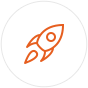

In [114]:
# let us access an account named publisher1
publisher1 = gis.users.get('publisher1')
publisher1

In [116]:
#list all folders as dictionaries
publisher1_folder_list = publisher1.folders
publisher1_folder_list

[{'created': 1479773023422,
  'id': '318b56a2280d49d0894c0b7ac66e01fd',
  'title': 'f1_english',
  'username': 'publisher1'},
 {'created': 1479773023854,
  'id': 'b9680c43ee184e1faa5aa9990359ac6a',
  'title': 'f2_敏感性增加',
  'username': 'publisher1'},
 {'created': 1479773024225,
  'id': '1bafef1c4bf54a108d1b85f0f5ae7d3e',
  'title': 'f3_Kompatibilität',
  'username': 'publisher1'}]

In [118]:
# list all items belonging to this user
publisher1_item_list_rootfolder = publisher1.items()
print("Total number of items in root folder: " + str(len(publisher1_item_list_rootfolder)))

#access the first item for a sample
publisher1_item_list_rootfolder[0]

Total number of items in root folder: 33


<Item title:"set1_Chicago" type:CSV owner:publisher1>

In [119]:
# list all items in the first folder
publisher1.items(folder = publisher1_folder_list[0])

[<Item title:"set1_major_cities" type:Locator Package owner:publisher1>,
 <Item title:"set1_shifting_opportunity" type:Image owner:publisher1>,
 <Item title:"set1_DSHS_Regions" type:KML owner:publisher1>,
 <Item title:"set1_Counties" type:KML owner:publisher1>,
 <Item title:"set1_Counties" type:KML owner:publisher1>,
 <Item title:"set1_shifting_opportunity" type:Image owner:publisher1>,
 <Item title:"set1_shifting_opportunity" type:Image owner:publisher1>]

Thus using a `GIS` object created with an account that has admin privileges, you were able to query the contents of another user without knowing that user's password or logging in as that user.

<a id="reassigning-user-content"></a>
### Reassigning user content
As an administrator, you have the privileges to list and view other users' content. When the time comes to delete a user account, you can filter these items and choose to preserve some of them and delete the rest.

Let us delete the `tiles_pub_user` account we created earlier in this guide.

In [120]:
# list the items owned by the user
tiles_pub_user_items = tiles_pub_user.items()
tiles_pub_user_items

[<Item title:"ocean_tiles" type:Map Service owner:tiles_publisher>,
 <Item title:"ocean_tiles2" type:Map Service owner:tiles_publisher>,
 <Item title:"Transport_tiles" type:Map Service owner:tiles_publisher>,
 <Item title:"income_by_county" type:Map Service owner:tiles_publisher>,
 <Item title:"counties_by_population" type:Map Service owner:tiles_publisher>,
 <Item title:"ocean_tiles3" type:Map Service owner:tiles_publisher>]

You can reassign specific items to another user by calling the `reassign_to()` method on that `Item` object. Let us reassign the tile layer named `Transport_tiles` to `publisher1` account from earlier. We can get rid of the redundant ocean_tiles items and reassign the rest, to the account `arcgis_python_api`. Since this user does not have privilege to create groups, we do not have to worry about that. We can then delete this user safely.

<Item title:"Transport_tiles" type:Map Service owner:tiles_publisher>
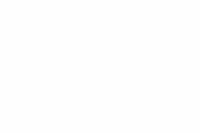

In [121]:
# reassign Transport_tiles to publisher1
transport_tiles_item = tiles_pub_user_items[2]
transport_tiles_item

In [122]:
# the reassign_to() method accepts user name as a string. We can also specify a destination folder name
transport_tiles_item.reassign_to(target_owner = 'publisher1', target_folder= 'f1_english')

True

In [123]:
# now let us get rid of redundant ocean tiles items
tiles_pub_user_items[1].delete()

True

In [124]:
tiles_pub_user_items[-1].delete()  # an index of -1 in a list refers to the last item

True

Now we are left with a few more items which should all go to user `arcgis_python_api`. We can either call `reassign_to()` method of the `User` object or call the `delete()` method of the `User` object and pass this information to the `reassign_to` parameter. Let's do that:

In [125]:
tiles_pub_user.delete(reassign_to='arcgis_python_api')

True

Thus, we have successfully deleted a user after taking care of that user's content.